## BAYESIAN CLASSIFICATION using UNIVARIATE GAUSSIAN MODELS
### CASE STUDY: Recognize Gender from PITCH

Purpose:  illustrate one of the simplest setups in machine learning on a simple speech problem

We make use of the Hillenbrand database and a simple Bayesian model.
We make use of the scikit-learn toolkit and our own pyspch wrapper around it for multiclass applications.

+ Author: Dirk Van Compernolle   
+ History:   
    - 2020: Created
    - 10/01/2022: in the call to skmetrics.confusion_matrix() an argument was missing.  This had no influence on this codebook with default parameters, but could produce wrong labels in the confusion matrix when changing classes or data.
    - 25/04/2022: upgrade to pyspch>=0.6
+ Requires:
    - pyspch>=0.6

### 1. Setting up your Python Environment
+ we load the default Python's Machine Learning Stack i.e. a number of modules that are used across a very wide range of machine learning tasks
    - scipy, numpy & pandas are used for data manipulation and computations
    - matplotlib and seaborn are used for plotting
    - sklearn is Python's elementary machine learning toolkit
+ some local utilities from pyspch
    - I/O tools for the Hillenbrand database
    - GaussianMixtureClf: our classifier using Gaussian Mixture Models
    with a UI that is compatible with sklearn 

In [10]:
# Importing Python's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git
except:
  IN_COLAB = False

from pyspch.GaussianMixtureClf import GaussianMixtureClf
from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand
#
# installing a colorpalette and markers that can handle the 12 class data 
colors = ['blue','green','red','magenta','maroon', 'darkorange','steelblue', 'darkviolet', 'gold','limegreen',   'darkkhaki', 'cyan','skyblue', ]
markers = ('o', 'P','v', '^', '<', '>', 'X','8', 's', '*', 'h', 'H', 'D', 'd', 'P','p')
#
#cp = sns.color_palette(colors12)
#sns.set_palette(cp)
#sns.palplot(cp)
# 
np.set_printoptions(precision=2)
# Pretty Print routine makes for confusion matrices
def plot_confusion_matrix(cf_mat,labels=[],cmap='Blues'):
    f,ax = plt.subplots()
    sns.heatmap(cf_mat, annot=True,fmt="d",square=True,
                annot_kws={"fontsize": 14},xticklabels=labels,yticklabels=labels,
                linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For details see DataExploration.ipynb notebook
https://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt


In [11]:
hildf = fetch_hillenbrand(genders='adults').dropna()
X = np.array(hildf.loc[:,['f0']])
y = np.array(hildf.loc[:,'gender'])
classes = np.unique(y)
print(hildf.head())


      gender vowel     f0     F1      F2      F3
fid                                             
m01ae      m    ae  174.0  663.0  2012.0  2659.0
m02ae      m    ae  102.0  628.0  1871.0  2477.0
m03ae      m    ae   99.0  605.0  1812.0  2570.0
m04ae      m    ae  124.0  627.0  1910.0  2488.0
m06ae      m    ae  115.0  647.0  1864.0  2561.0


### 3. Modeling Pitch data with a Gaussian Model

In the first set of experiments we focus on modeling f0, and later recognizing gender on the basis of it.
If we may assume that all our data has been (correctly) labeled, then we can get view of the data 'per class'. For 1-D observations, as in this case, we observe with histograms.
The plot below shows a simple 2 class histogram  and a Gaussian fit.

We use the GaussianMixture functions from the sklearn package to model each of the histograms by a (single) Gaussian.

It may all look simple and trivial. However, some intuitive assumptions may rightfully be questioned.  We will explore two such things:  the number of bins in the histogram and the scaling of
the feature axis.

#### Tasks & Questions (1):
1. The principle parameter that you can adjust in the code block below is the 'n_bins' parameter.  It sets the number of bins in the histograms.  There is no ABSOLUTE trutch value for n_bins. Try to explain how n_bins is related to the size of your database, the number of classes and/or the dimensionality of the feature vectors ?
2. Up till now we expressed pitch in the common physical unit 'Hz'.  However, from a musical perspective it is more common to express pitch on a musical/logarithmic scale.  In Western music an octave is divided into 12 equal parts on a logartihmic scale, also called *semitones*. Be aware that such musical scale, just as any other logarithmic scale, is a relative scale.  Do you see differences in how the data is distributed on a Hz or on a semitone scale ?  Is the Gaussian assumption work better for either scale ?  

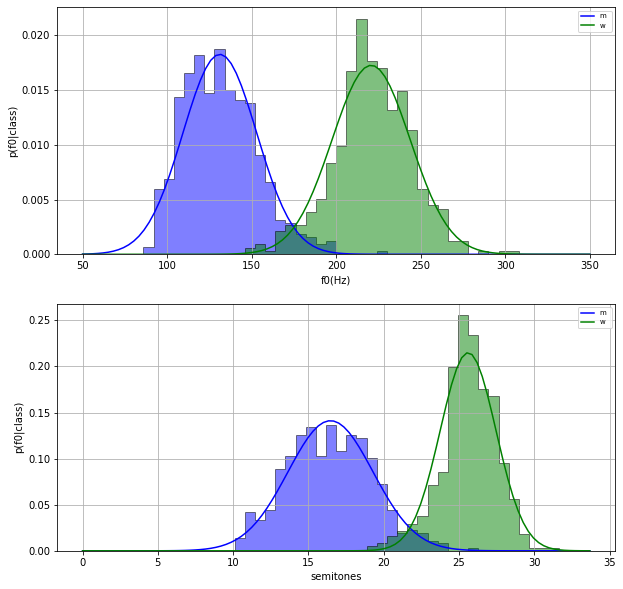

In [12]:
freq_scale = "Hz"                    # should be 'Hz' or 'semitones'
fit_gaussians = True                 # should be True or False
n_bins = 50                          # number of bins in the histograms
f0_range = np.asarray([50., 350.])   # frequency range in histograms
f0base = 50.                         # reference frequency (in Hz) for semitone scale

plt.close('all')
def freq2st(f,base=f0base):
    return 12*np.log2(f/base)

#
x1 = X[y=='m',:]
x2 = X[y=='w',:]
y1 = y[y=='m']
y2 = y[y=='w']

xlab = 'f0(Hz)'
ylab = 'p(f0|class)'

fig,ax = plt.subplots(2,1,figsize=(10,10))

for i in range(0,2):    
    if i == 1:
        x1= freq2st(x1)
        x2= freq2st(x2)
        f0_range = freq2st(f0_range)
        xlab = 'semitones'
    kwargs = dict(histtype='stepfilled', alpha=.5, bins=n_bins, density=True, ec="k")
    ax[i].hist(x1, **kwargs,range=f0_range,color=colors[0])
    ax[i].hist(x2, **kwargs,range=f0_range,color=colors[1])
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(ylab)
    ax[i].grid(True)
    if(fit_gaussians):
        xp  = np.linspace(f0_range[0],f0_range[1],100).reshape(-1,1)
        for j in range(0,2):
            if(j==0):
                xdata = x1
            else:
                xdata = x2
            gmm = GaussianMixture(max_iter=3,random_state=1,n_components=1,init_params='kmeans')
            gmm.fit(xdata)
            yp = gmm.score_samples(xp)
            ax[i].plot(xp,np.exp(yp),label='%s ' % classes[j],color=colors[j])
        ax[i].legend(loc='upper right',fontsize='x-small')

plt.show()

### 4. Classification using a Bayesian classifier and Gaussian models

We know now enough to create and test our classifier
1. split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. train the classifier based on the training data
    - given the data exploration before we choose to model the data in each class with a single Gaussian distribution 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data; look at overall score 
5. look more in detail to a confusion matrix (next codeblock)

For this, we will use the class *GaussianMixtureClass* which is provided in *spchutils* .
It is implemented as an extension to *sklearn*, making use of the sklearn GaussianMixture density estimator, as we used before. 

There are a number of parameters that you may adjust in the following code blocks
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   
- random_state:  you can modify this to have a different division between train and test sets and see if you get different results


#### Task & Questions (2)
1. What Accuracy do you obtain ?
2. Do you observe great variability on accuracy when you modify the amount of training data that is used ?  What does this tell you ?
3. Specify different priors_test: (i)  specify 80% prior for males (ii) specify 100% prior for female.   What happens to the overall accuracy and confusion matrix ? Explain why things are going worse.

In [13]:

# --------------
n_components = 1
train_size=0.5
random_state=0     # sets initialization of RNG for selecting train/test data, set to None to be random
priors_test = None # should be None or a vector of type e.g. [0.8 , 0.2] expects 80% male
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=random_state)
clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components)
clf_GM.fit(X_train,y_train)
# 2. print the model
clf_GM.print()
#print("Classes: ",clGM.classes_)
y_pred = clf_GM.predict(X_test,priors=priors_test)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

Class[0] (m) with prior=0.495
-----------------------------------
   weights        mean    std_dev
0      1.0  130.481481  20.568171

Class[1] (w) with prior=0.505
-----------------------------------
   weights        mean    std_dev
0      1.0  221.145455  22.304193

Accuracy: 94.86%


### Confusion Matrix
A confusion matrix gives a more detailed image of the errors that we make.   
The global accuracy averages over all confusable pairs, while a confusion matrix will hint to more and less confusable pairs or it may also hint at asymmetry in the recognizer.

Accuracy: 94.86%


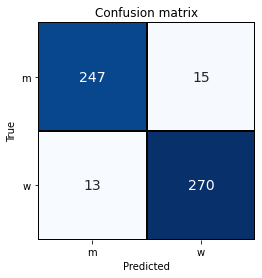

In [14]:
y_pred = clf_GM.predict(X_test, priors=[.5 , .5])
cf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=classes) 
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))    
plot_confusion_matrix(cf_mat,labels=classes)

### Cross Validation
Instead of using a single fixed split between train and test
we often prefer to evaluate our algorithms using a **cross validation** procedure.   
In a cross validation setup we split the full dataset randomly in **N folds** of roughly equal size.  Then we take each of the folds as test_set and train on the combined data in the remaining folds.
Finally we aggregate the results.  This is a fair approach as each sample in the database was used exactly once as test sample.   
This procedure is especially useful for small datasets.
For the current problem the dataset is big enough and a simple train/test split did a fair job.

In [15]:
nfolds = 10
scores = cross_val_score(clf_GM, X, y, cv=nfolds)
print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))

Average Cross validation score for 10 folds: 95.96 % correct


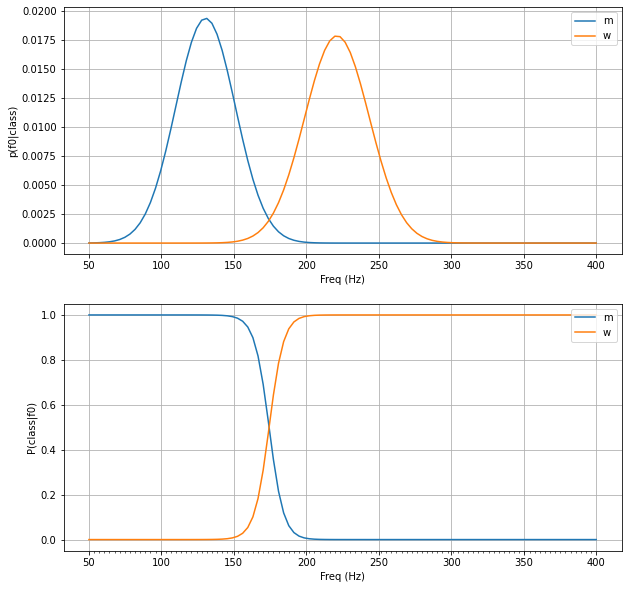

In [16]:
# have a look at the internals of the classifier
# by looking at likelihoods per class and 
# predicted probabilities per class over the whole pitch range
x = np.vstack(np.linspace(50.,400.,100))
fig,ax = plt.subplots(2,1,figsize=(10,10))

# 1. likelihoods
z = clf_GM.predict_prob(x)
h = ax[0].plot(x,z)
ax[0].set_xlabel("Freq (Hz)")
ax[0].set_ylabel("p(f0|class)")
ax[0].legend(classes,loc='upper right')
ax[0].grid(True)
# 2. posteriors
z = clf_GM.predict_proba(x)
h = ax[1].plot(x,z)
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("P(class|f0)")
ax[1].legend(classes,loc='upper right')
ax[1].grid(True)
ax[1].set_xticks(x,minor=True)
plt.show()

### 5. Can you do it yourself ?

Do you really understand all the underlying formulas that are being used.
You should be able to do predictions yourself on the basis of the model parameters .. and you don't need a calculator.

#### Task & Questions (3)
1. Get a detailed printout of your current model
2. Create an independet test vector in my_test, with values of your choice
3. Run the predictions made by the model
4. Now try to replicate all computations for one of the values
5. Given your classifier, can you make a prediction on the global error rate ? 
6. Include 135Hz and 145Hz in the test samples.  First, observe that in the full Hillenbrand database the lowest female pitch is 149Hz. What would your intuitive answer (guess) be on classification and posteriors.  Now observe the predictions given by the model. How do you explain the rather big differences beween the two predicted posteriors ?

<img src="normal_distribution.png" style="height:10cm"/>

In [17]:
my_test = np.array([89., 135., 145., 173., 199., 240., 112., 288.]).reshape(-1,1)
priors=None
# verify the values of the model
clf_GM.print()
#
print(clf_GM.predict_proba(my_test,priors=priors))
print(clf_GM.predict(my_test,priors=priors))

Class[0] (m) with prior=0.495
-----------------------------------
   weights        mean    std_dev
0      1.0  130.481481  20.568171

Class[1] (w) with prior=0.505
-----------------------------------
   weights        mean    std_dev
0      1.0  221.145455  22.304193

[[1.00e+00 1.71e-07]
 [9.99e-01 5.54e-04]
 [9.96e-01 3.54e-03]
 [5.64e-01 4.36e-01]
 [6.74e-03 9.93e-01]
 [1.06e-06 1.00e+00]
 [1.00e+00 8.88e-06]
 [1.75e-11 1.00e+00]]
['m', 'm', 'm', 'm', 'w', 'w', 'm', 'w']
